# GMT mapping function based on Forster et al 2024 data

Find present-day warming period in models as closest end point in 10 year warming trend, from new Forster 2024 data on obs warming

Todo: do also for 1.5 deg warming, and find also year in SSP for demographics ! 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), openpyxl?, cartopy?

import numpy as np
import pandas as pd
import os, glob
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt


# My settings and functions
from settings import *
start_message() 

from functions import *

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': (1901, 2019), 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/o

/apps/brussel/RL8/skylake/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%matplotlib inline

In [3]:

flags['models'] = 'ISIMIP3b'
df_gmst_mod = merge_model_gmst(GCMs, dir_gmst_models)
df_gmst_mod

,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
year,,,,,,
1850,0.096275,0.07598,-0.094941,-0.184196,-0.068196,0.062608
1851,-0.149725,0.03998,-0.151941,-0.016196,-0.095196,0.087608
1852,-0.101725,0.00998,0.027059,-0.032196,-0.079196,0.021608
1853,0.038275,0.03198,0.061059,0.036804,-0.019196,-0.052392
1854,-0.075725,0.03098,-0.113941,0.107804,0.191804,-0.107392
...,...,...,...,...,...,...
2096,6.090275,4.75998,3.465059,5.281804,3.370804,3.743608
2097,6.278275,4.75398,3.466059,5.512804,3.036804,3.795608
2098,6.364275,4.95798,3.442059,5.356804,3.112804,3.624608


In [4]:
# annual obs warming
df_gmst_obs_annual = pd.read_csv(os.path.join(observed_warming_path_annual)).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]

# decadal avg obs warming
df_gmst_obs_decadal = pd.read_csv(observed_warming_path).rename(
    columns={'timebound_upper':'year'}).set_index('year')[['gmst']]
df_gmst_obs_decadal.index = df_gmst_obs_decadal.index-1

## try two different methods: AR6 and SR1.5

AR6 (end-point of 10-year average), very jumpy for early decades, but ok recently. SR1.5 (central point of 30-year average, extending current warming rate) is less jumpy but underestimates warming in most recent decades, since rate of warming is accellerating. 

In [5]:
df_gmst_obs_decadal

,gmst
year,
1859,0.016554
1860,0.016554
1861,0.000054
1862,-0.027196
1863,-0.034446
...,...
2019,1.071304
2020,1.097054
2021,1.119554


In [19]:
da_gmt_mapping_ar6 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path,
                                          method='ar6',
                                          min_periods=10,
                                          flatten=False)

da_gmt_mapping_sr15 = calc_warming_periods_models_all_years(GCMs, 
                                          dir_gmst_models, 
                                          observed_warming_path_annual,
                                          method='30-yr',
                                          min_periods=10,
                                          flatten=False)

In [12]:
da_gmt_mapping_ar6.sel(feature='year_mod').to_pandas()

model,obs,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
year,,,,,,,
1859,1859,1908,1946,1875,1902,1872,1895
1860,1860,1908,1946,1875,1902,1872,1895
1861,1861,1874,1876,1882,1900,1859,1864
1862,1862,1871,1901,1871,1884,1905,1894
1863,1863,1868,1902,1884,1884,1895,1889
...,...,...,...,...,...,...,...
2019,2019,2004,2021,2029,2009,2034,2021
2020,2020,2004,2022,2031,2010,2034,2021
2021,2021,2005,2023,2032,2011,2035,2022


<AxesSubplot:xlabel='year'>

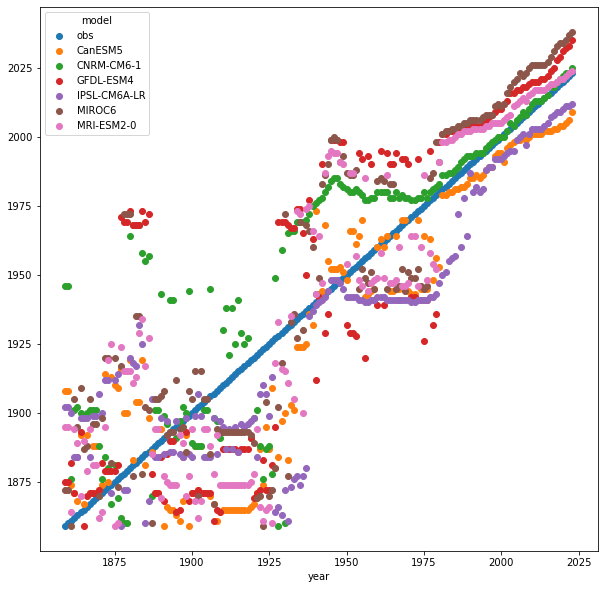

In [18]:
da_gmt_mapping_ar6.sel(feature='year_mod').to_pandas().plot(marker='o', ls='',figsize=(10,10)) # possibly show this fig in SI just from 2000 !

<AxesSubplot:xlabel='year'>

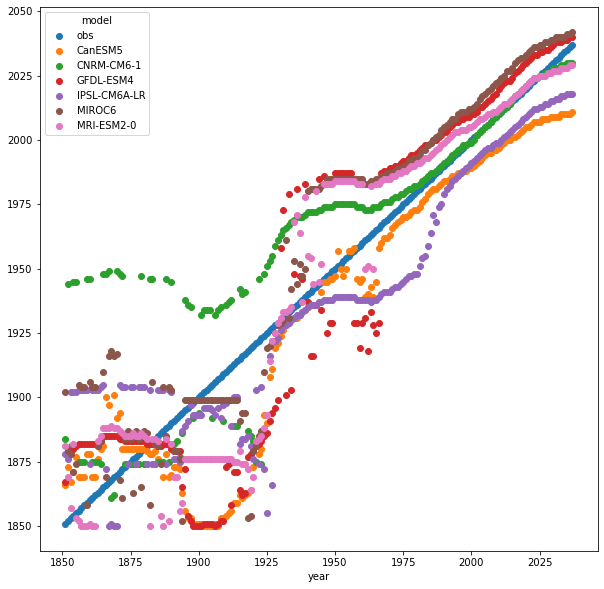

In [20]:
da_gmt_mapping_sr15.sel(feature='year_mod').to_pandas().plot(marker='o', ls='',figsize=(10,10))

## save AR6 method output updated with Forster 2024

In [22]:
# filesavepath = os.path.join(outdirs, 'output_gmt-mapping/df_gmt_mapping_1859_2023_forster2024.csv')
# df_save = da_gmt_mapping_ar6.sel(feature='year_mod').to_pandas()
# df_save.to_csv(filesavepath)

## compare with Forster 2023

In [45]:
df_new = df_save

df_old = pd.read_csv(os.path.join(outdirs, 'output_gmt-mapping/df_gmt_mapping_1859_2022_v270324'),index_col=0)
year_cols = [col for col in df_old.columns if 'year' in col]
df_old = df_old[year_cols]
df_old =df_old.set_axis(df_new.columns[1:], axis=1)



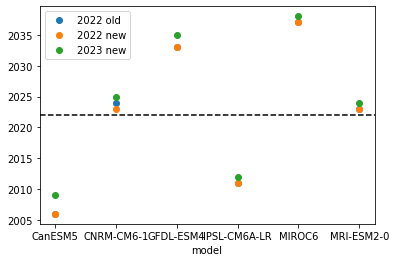

In [58]:
fig,ax=plt.subplots()

df_old.loc[2022].plot(marker='o', ls='',ax=ax,label='2022 old')
df_new.loc[2022][1:].plot(marker='o', ls='',ax=ax,label='2022 new')
df_new.loc[2023][1:].plot(marker='o', ls='',ax=ax,label='2023 new')
ax.axhline(2022, ls='--',c='k')
plt.legend()

In [50]:
df_old.loc[2022]

model
CanESM5         2006
CNRM-CM6-1      2024
GFDL-ESM4       2033
IPSL-CM6A-LR    2011
MIROC6          2037
MRI-ESM2-0      2023
Name: 2022, dtype: int64

In [48]:
df_new.loc[2022][1:]

model
CanESM5         2006
CNRM-CM6-1      2023
GFDL-ESM4       2033
IPSL-CM6A-LR    2011
MIROC6          2037
MRI-ESM2-0      2023
Name: 2022, dtype: object

In [60]:
df_new.loc[2023][1:]

model
CanESM5         2009
CNRM-CM6-1      2025
GFDL-ESM4       2035
IPSL-CM6A-LR    2012
MIROC6          2038
MRI-ESM2-0      2024
Name: 2023, dtype: object